# Conceptual drawing for the polytope figure for NSF-AI whitepaper

1. simply showing a true posterior for XOR, and then that posterior but partitioned into 4 polytopes (and the magnitude per polytope is just the average over that space), and then another one for 64 polytopes.
2. given the polytopes (either 4 or 64), a plot of estimated Risk vs. sample size for XOR, XNOR, and RXOR.  i'm guessing the 64 will converge much slower than the 4 for XOR and XNOR, but for RXOR, it will converge to something with a far lower risk.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import random
from scipy.spatial import Voronoi, voronoi_plot_2d

from util import true_xor, generate_mask, generate_gaussian_parity
from util import generate_polytope, calculate_risks, voronoi_finite_polygons_2d

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
seed = 1234 #random seed
rng = 1 #data range
h = 0.04 #definition (affects number of sample)

## Generate True Posterior

In [3]:
# this takes too long to run
trueXOR = true_xor(rng=rng, h=h, rotate=False, newpdf=True)

In [4]:
trueXOR_old = true_xor(rng=rng, h=h, rotate=False, newpdf=False)

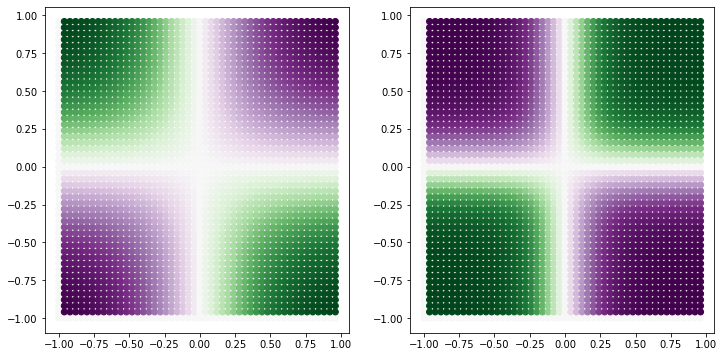

In [5]:
fig, ax = plt.subplots(1,2, figsize=(6*2,6))

ax[0].scatter(trueXOR[0],trueXOR[1],c=trueXOR[2],cmap='PRGn')
ax[1].scatter(trueXOR_old[0],trueXOR_old[1],c=trueXOR_old[2],cmap='PRGn')

## Generate Posterior Image

#### Create a grid

In [6]:
grid = generate_mask(rng=rng, h=h)
N = grid.shape[0]
grid.shape

(2500, 2)

#### Train `RF` and `DN`

In [7]:
X, y = generate_gaussian_parity(n_samples=N)
X1, y1 = generate_gaussian_parity(n_samples=N, angle_params=np.pi/4)
X2, y2 = generate_gaussian_parity(n_samples=N, angle_params=np.pi/2)

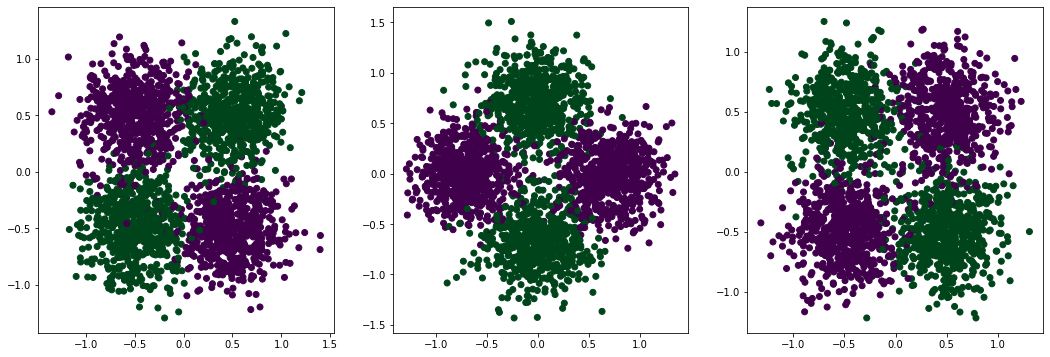

In [8]:
fig, ax = plt.subplots(1,3, figsize=(6*3,6))
ax[0].scatter(X[:,0],X[:,1],c=y,cmap='PRGn')
ax[1].scatter(X1[:,0],X1[:,1],c=y1,cmap='PRGn')
ax[2].scatter(X2[:,0],X2[:,1],c=y2,cmap='PRGn')

In [9]:
clf_rf = RandomForestClassifier()
clf_mlp = MLPClassifier()

In [10]:
clf_rf.fit(X,y)
clf_mlp.fit(X,y)

MLPClassifier()

In [11]:
pred_rf = clf_rf.predict_proba(grid)
pred_mlp = clf_mlp.predict_proba(grid)

#### Generate a posterior plot

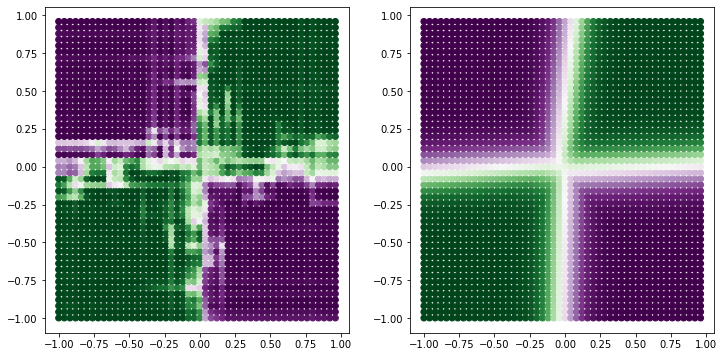

In [12]:
fig, ax = plt.subplots(1,2, figsize=(6*2,6))
ax[0].scatter(grid[:,0], grid[:,1], c=pred_rf[:,1], cmap='PRGn')
ax[1].scatter(grid[:,0], grid[:,1], c=pred_mlp[:,1], cmap='PRGn')

## Create synthetic polytope regions

#### Create reference points for polytope

In [13]:
choice = random.choices(grid,k=64)
choice = np.array(choice)
choice.shape

(64, 2)

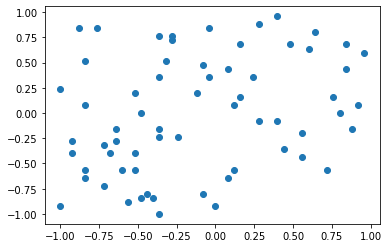

In [14]:
plt.scatter(choice[:,0], choice[:,1])

#### Create N polytopes using voronoi algorithm

In [15]:
vr = Voronoi(choice)

#### Plot polytope backbone

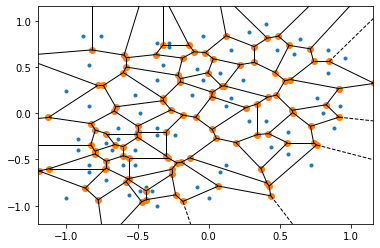

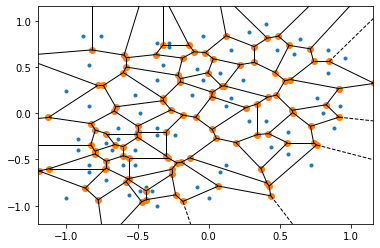

In [16]:
voronoi_plot_2d(vr)

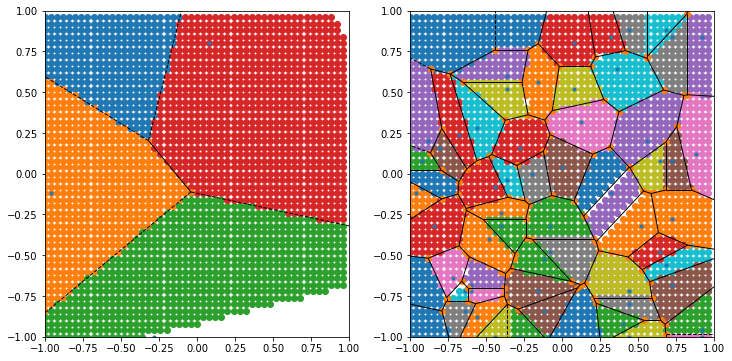

In [17]:
fig, ax = plt.subplots(1,2, figsize=(6*2,6))

for ix, k in enumerate([4, 64]):

    random.seed(seed)

    choice = random.choices(grid, k=k)
    choice = np.array(choice)

    vr = Voronoi(choice[:,:2])

    polytope_points = []

    regions, vertices = voronoi_finite_polygons_2d(vr)

    for region in regions:
        poly = [vertices[i] for i in region]
        p = Path(poly)
        vrt = grid[p.contains_points(grid[:,:2])]
        polytope_points.append(vrt)

    for coor in polytope_points:
        ax[ix].scatter(coor[:,0],coor[:,1])

    voronoi_plot_2d(vr, ax=ax[ix])

    ax[ix].set_xlim(-1,1)
    ax[ix].set_ylim(-1,1)

## Polytope Experiment

#### Create N polytopes using training data

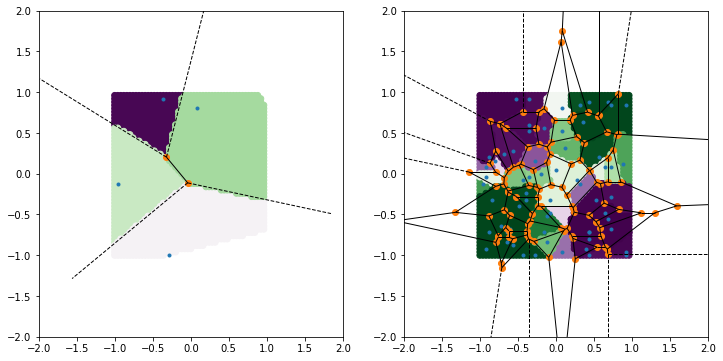

In [18]:
polytope_points = generate_polytope(rng=rng, h=h, label=pred_rf[:,1].reshape(-1,1), grid=grid, seed=seed)

#### Experiment to calculate mean error using true posterior

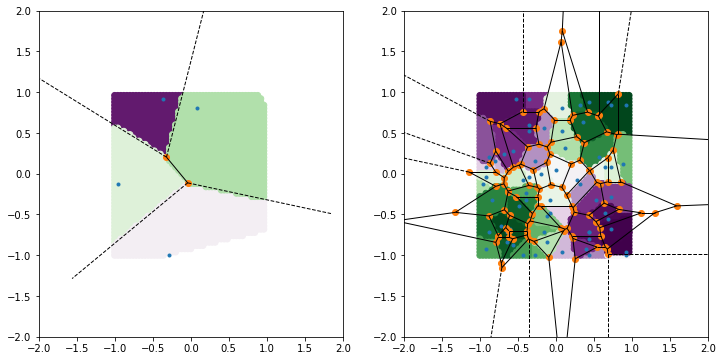

In [19]:
tp = trueXOR_old #alias

polytope_points_true = generate_polytope(rng=rng, h=h, label=tp[2].reshape(-1,1), grid=grid, seed=seed)

In [20]:
np.mean(abs(np.array([i[0][2] for i in polytope_points]) - np.array([i[0][2] for i in polytope_points_true])))

0.020469505009548243

#### Experiment to calculate the risk
The definition of the risk here is the expected mis-classification error.
The test simulation of the given XOR dataset is used to calculated the mis-classification error. The averaged posterior within each polytope of the prediction computed from training data is subsequently converted into a class. The risk based on whether each point from test data is correctly reside within the polytope is calculated here.

- Get class 1 posterior from training data
- Change each polytope, where they're initially the average of class 1 probability, into a class
- Match test data to the polytope generated by the training data
- Compute the expected mis-classification error
- Do this for [RF, DN] with [XOR, RXOR, NXOR] over different sample size between [4, 64] polytopes

In [21]:
#create test data
X, y = generate_gaussian_parity(n_samples=N)
X = np.append(X,y.reshape(-1,1),axis=1)

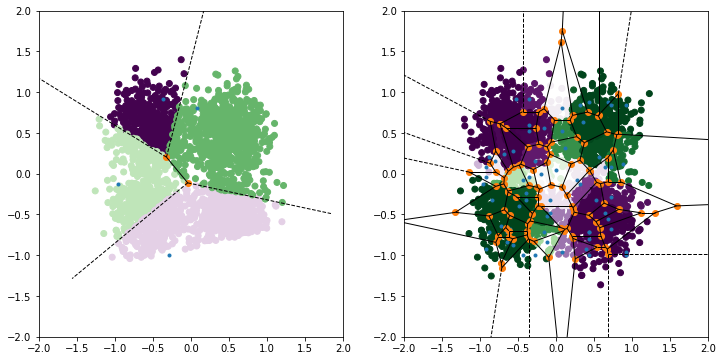

In [22]:
polytope_points_test = generate_polytope(rng=rng, h=h, grid=grid, seed=seed, test=X)

In [23]:
pA = polytope_points
pB = polytope_points_test

polylist = [4,64]
risks = [[] for _ in range(len(polylist))]
cnts = [[] for _ in range(len(polylist))]

for ix, k in enumerate(polylist):

    risk = 0
    cnt = 0

    for pp, pp_test in zip(pA[ix], pB[ix]):
        for ppt in pp_test:
            cnt += 1
            print(cnt, np.argmax([0.5, pp[0][2]]), int(ppt[2]), int(np.argmax([0.5, pp[0][2]]) != int(ppt[2])))
            risk += int(np.argmax([0.5, pp[0][2]]) != int(ppt[2]))

    cnts[ix] = cnt
    risks[ix] = risk

1 0 0 0
2 0 0 0
3 0 0 0
4 0 0 0
5 0 0 0
6 0 0 0
7 0 0 0
8 0 0 0
9 0 0 0
10 0 0 0
11 0 0 0
12 0 0 0
13 0 0 0
14 0 0 0
15 0 0 0
16 0 0 0
17 0 0 0
18 0 0 0
19 0 0 0
20 0 0 0
21 0 0 0
22 0 0 0
23 0 0 0
24 0 0 0
25 0 0 0
26 0 0 0
27 0 0 0
28 0 0 0
29 0 0 0
30 0 0 0
31 0 0 0
32 0 0 0
33 0 0 0
34 0 0 0
35 0 0 0
36 0 0 0
37 0 0 0
38 0 0 0
39 0 0 0
40 0 0 0
41 0 0 0
42 0 0 0
43 0 0 0
44 0 0 0
45 0 0 0
46 0 0 0
47 0 0 0
48 0 0 0
49 0 0 0
50 0 0 0
51 0 0 0
52 0 0 0
53 0 0 0
54 0 0 0
55 0 0 0
56 0 0 0
57 0 0 0
58 0 0 0
59 0 0 0
60 0 0 0
61 0 0 0
62 0 0 0
63 0 0 0
64 0 0 0
65 0 0 0
66 0 0 0
67 0 0 0
68 0 0 0
69 0 0 0
70 0 0 0
71 0 0 0
72 0 0 0
73 0 0 0
74 0 0 0
75 0 0 0
76 0 0 0
77 0 0 0
78 0 0 0
79 0 0 0
80 0 0 0
81 0 0 0
82 0 0 0
83 0 0 0
84 0 0 0
85 0 0 0
86 0 0 0
87 0 0 0
88 0 0 0
89 0 0 0
90 0 0 0
91 0 0 0
92 0 0 0
93 0 0 0
94 0 0 0
95 0 0 0
96 0 0 0
97 0 0 0
98 0 0 0
99 0 0 0
100 0 0 0
101 0 0 0
102 0 0 0
103 0 0 0
104 0 0 0
105 0 0 0
106 0 0 0
107 0 0 0
108 0 0 0
109 0 0 0
110 0 0 0
111 0 0 

In [24]:
X.shape, cnts, risks, len(pA[0][0])

((2500, 3), [2399, 2591], [1190, 734], 304)

In [25]:
for i,j in zip(risks, cnts):
    print(i/j)

0.496040016673614
0.2832883056734851
